In [98]:
!pip install PyPortfolioOpt
!pip install yfinance
!pip install scikit-opt

In [99]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sko.PSO import PSO
from numpy.polynomial.polynomial import polyfit, polyval
from pypfopt import expected_returns, risk_models

In [100]:
# --- Data Fetching ---
def get_data(portfolio, start_date, end_date):
    """
    Fetches historical adjusted closing price data for a list of tickers using yfinance.

    Args:
        portfolio (list or str): A list of stock tickers (e.g., ['AAPL', 'MSFT']) or a single ticker string.
        start_date (str): The start date for the data in 'YYYY-MM-DD' format.
        end_date (str): The end date for the data in 'YYYY-MM-DD' format.

    Returns:
        pandas.DataFrame: A DataFrame containing the adjusted closing prices for the requested tickers,
                          with dates as the index. Rows with all NaN values are dropped.
                          Returns an empty DataFrame if data fetching fails or results in no data.
    """
    print(f"Fetching data for: {portfolio} from {start_date} to {end_date}")
    try:
        # Download data using yfinance
        data = yf.download(portfolio, start=start_date, end=end_date, auto_adjust=True, progress=False)

        # --- Handle different possible column structures returned by yfinance ---
        # yfinance might return a MultiIndex DataFrame (e.g., ('Adj Close', 'AAPL'))
        # or a single-level index DataFrame (e.g., 'Adj Close' if only one ticker)
        # or just 'Close' if 'Adj Close' is not available.

        if isinstance(data.columns, pd.MultiIndex):
            # If MultiIndex, try to select 'Adj Close' level
            if 'Adj Close' in data.columns.levels[0]:
                data = data['Adj Close']
            # If 'Adj Close' not found, try 'Close'
            elif 'Close' in data.columns.levels[0]:
                 data = data['Close']
            # Fallback: Select columns where the second level of the multi-index is empty
            # This can sometimes happen with certain data pulls.
            else:
                 data = data.iloc[:, data.columns.get_level_values(1)=='']
        # If single-level columns (e.g., when downloading a single ticker), check for 'Close'
        elif 'Close' in data.columns:
             data = data['Close']
        # If neither 'Adj Close' nor 'Close' is found directly, the structure might be unexpected.
        # We assume the relevant price is in the main columns if not multi-indexed and not 'Close'.
        # This part implicitly handles the case where 'Adj Close' might be the single-level column name.

        # --- Ensure DataFrame output, even for a single ticker ---
        # yfinance returns a Series for a single ticker download. Convert it to a DataFrame.
        if isinstance(data, pd.Series):
            # Try to name the column with the ticker symbol if provided as a list
            col_name = portfolio[0] if isinstance(portfolio, list) and len(portfolio)==1 else 'Close'
            data = data.to_frame(name=col_name)

        # Drop rows where *all* tickers have NaN values (e.g., market holidays)
        return data.dropna(axis=0, how='all')

    except Exception as e:
        print(f"Error fetching data for {portfolio}: {e}")
        # Return an empty DataFrame on error to avoid downstream issues
        return pd.DataFrame()

In [101]:
# --- Portfolio Calculation Functions (Used by Objective Functions) ---
def portfolio_returns(prices, weights):
    """
    Calculates the daily returns of a portfolio given asset prices and weights.

    Args:
        prices (pandas.DataFrame): DataFrame of historical asset prices (e.g., adjusted close),
                                   with dates as index and tickers as columns.
        weights (numpy.ndarray or list): Array or list of asset weights, corresponding
                                         to the columns in the prices DataFrame.

    Returns:
        pandas.Series: A Series of daily portfolio returns. Returns a Series of zeros if
                       weights sum to zero or if there's a shape mismatch. Returns an empty Series
                       if input price data leads to empty returns.
    """
    # Calculate daily percentage change for each asset
    returns_assets = prices.pct_change()
    # Drop the first row (NaN) resulting from pct_change()
    returns_assets = returns_assets.dropna(axis=0, how='all') # Drop rows with all NaNs first

    if returns_assets.empty:
        return pd.Series(dtype=float) # Return empty series if no returns data

    # Drop remaining rows with any NaN (ensures alignment for dot product)
    returns_assets = returns_assets.dropna()

    if returns_assets.empty:
        print("Warning: No valid returns after dropping NaNs in portfolio_returns.")
        return pd.Series(dtype=float) # Return empty series if dropping NaNs removed all data

    # Ensure weights is a flat numpy array for calculations
    weights_flat = np.array(weights).flatten()

    # --- Basic validation ---
    if len(weights_flat) != len(returns_assets.columns):
         # This error is critical for correct calculations
         raise ValueError(f"Number of weights ({len(weights_flat)}) does not match number of assets ({len(returns_assets.columns)})")

    # --- Normalize weights if they don't sum to 1 ---
    # Optimizers often produce weights that are close but not exactly 1.
    weights_sum = np.sum(weights_flat)
    if not np.isclose(weights_sum, 1.0):
        # If weights sum to exactly 0 (e.g., initial state or error), return zero returns
        if weights_sum == 0:
             print("Warning: Weights sum to zero in portfolio_returns. Returning zero returns.")
             # Return a Series of zeros with the same index as asset returns
             return pd.Series(0.0, index=returns_assets.index)
        # Normalize weights to sum to 1
        # print(f"Note: Normalizing weights from sum {weights_sum:.6f} to 1.0") # Optional: for debugging
        weights_flat = weights_flat / weights_sum

    # --- Calculate portfolio returns ---
    # Use pandas Series for weights to align with DataFrame columns during dot product
    # This ensures that weights are multiplied by the correct asset returns even if column order changes.
    weights_series = pd.Series(weights_flat, index=returns_assets.columns)
    # The dot product calculates the weighted average return for each day
    returns_portfolio = returns_assets.dot(weights_series)

    return returns_portfolio

def cal_returns(returns):
    """
    Calculates the annualized geometric mean return from a series of daily returns.
    Falls back to arithmetic mean annualization if geometric calculation is invalid (cumulative return < -100%).

    Args:
        returns (pandas.Series): A Series of daily returns.

    Returns:
        float: The annualized geometric mean return. Returns 0.0 if input is empty.
               Returns -1.0 for exactly -100% cumulative return.
               Returns annualized arithmetic mean if cumulative return < -100%.
    """
    n = len(returns)
    # Handle empty input series
    if n == 0: return 0.0

    # --- Calculate Geometric Mean Return ---
    # Geometric mean is generally preferred for investment returns over time.
    # Formula: [(1+r1)*(1+r2)*...*(1+rn)]^(1/N) - 1
    # Annualized: [(1+r1)*(1+r2)*...*(1+rn)]^(252/N) - 1
    # where N is the number of trading days in the period.

    # Calculate cumulative return first: (1+r1)*...*(1+rn) - 1
    # Adding 1 before prod avoids issues with zero returns.
    cumulative_return = (1 + returns).prod() - 1

    # The base for the exponentiation is (1 + cumulative_return)
    base = 1 + cumulative_return

    # --- Handle Edge Cases ---
    # If base is negative (cumulative return < -100%), the geometric mean is mathematically undefined for fractional exponents.
    if base < 0:
        # Fallback to arithmetic mean annualization
        print("Warning: Cumulative return less than -100%. Falling back to arithmetic mean return annualization.")
        # Simple average daily return * number of trading days in a year (approx 252)
        return returns.mean() * 252
    # Handle exact -100% return (base is zero)
    elif base == 0:
        # An investment that goes to zero has a return of -100% or -1.0
        return -1.0
    # Standard case: base is positive
    else:
        # Calculate annualized geometric return
        # (trading days per year / number of days in period)
        annualization_factor = 252.0 / n
        return base ** annualization_factor - 1

def cal_volatility(returns):
    """
    Calculates the annualized volatility (standard deviation) from a series of daily returns.

    Args:
        returns (pandas.Series): A Series of daily returns.

    Returns:
        float: The annualized volatility. Returns 0.0 if input is empty or has zero variance.
    """
    # Handle empty input or returns with no variation
    if returns.empty or returns.std(ddof=1) == 0: return 0.0

    # --- Calculate Annualized Volatility ---
    # Volatility is the standard deviation of returns.
    # Calculate sample standard deviation (ddof=1 uses N-1 in the denominator, standard for samples)
    daily_std_dev = returns.std(ddof=1)
    # Annualize by multiplying by the square root of the number of trading days in a year (approx 252)
    return daily_std_dev * np.sqrt(252)

def cal_sharpe_ratio(ann_ret, ann_vol, risk_free):
    """
    Calculates the Sharpe ratio given annualized return, annualized volatility, and risk-free rate.

    Args:
        ann_ret (float): The annualized portfolio return.
        ann_vol (float): The annualized portfolio volatility.
        risk_free (float): The annualized risk-free rate.

    Returns:
        float: The Sharpe ratio. Returns 0.0 if annualized volatility is zero to avoid division by zero.
    """
    # Sharpe Ratio = (Annualized Return - Risk-Free Rate) / Annualized Volatility
    # Handle case where volatility is zero (e.g., risk-free asset or no price movement)
    if ann_vol == 0:
        # If return equals risk-free rate, ratio is undefined (or could be considered 0)
        # If return is higher than risk-free, could be considered infinite Sharpe (perfect risk-adjusted return)
        # Conventionally, return 0.0 or np.nan. Here we use 0.0.
        return 0.0
    # Calculate Sharpe ratio
    return (ann_ret - risk_free) / ann_vol

In [102]:
# --- Objective Functions for Optimization (Use historical simulation) ---
# These functions are designed to be *minimized* by the optimization algorithm (PSO).

def objective_function_sharpe(weights, prices, risk_free_rate):
    """
    Objective function: MINIMIZE the NEGATIVE Sharpe ratio (equivalent to maximizing Sharpe).
    Uses historical simulation.

    Args:
        weights (numpy.ndarray): Portfolio weights.
        prices (pandas.DataFrame): Historical asset prices.
        risk_free_rate (float): Annualized risk-free rate.

    Returns:
        float: Negative Sharpe ratio (or large penalty on error).
    """
    try:
        port_returns = portfolio_returns(prices, weights)
        if port_returns.empty: return 1e10 # Penalize failure

        ann_ret = cal_returns(port_returns)
        ann_vol = cal_volatility(port_returns)
        sharpe_ratio = cal_sharpe_ratio(ann_ret, ann_vol, risk_free_rate)

        # Minimize negative Sharpe to maximize Sharpe
        return -sharpe_ratio
    except Exception as e:
        print(f"Error in objective_function_sharpe: {e}")
        return 1e10 # Return penalty

def objective_function_volatility(weights, prices):
    """
    Objective function: MINIMIZE portfolio volatility.
    Uses historical simulation.

    Args:
        weights (numpy.ndarray): Portfolio weights.
        prices (pandas.DataFrame): Historical asset prices.

    Returns:
        float: Annualized portfolio volatility (or large penalty on error).
    """
    try:
        port_returns = portfolio_returns(prices, weights)
        if port_returns.empty: return 1e10 # Penalize failure

        ann_vol = cal_volatility(port_returns)
        return ann_vol
    except Exception as e:
        print(f"Error in objective_function_volatility: {e}")
        return 1e10 # Return penalty

# --- MODIFIED Optimization Function ---
def pso_optimize(prices, risk_free_rate, objective, n_particles=50, n_iterations=100):
    """
    Performs Particle Swarm Optimization (PSO) to find optimal portfolio weights.
    PSO uses historical simulation (via objective functions) for fitness evaluation.
    Final reported performance uses MVO-style calculations (mu, sigma) for consistency.

    Args:
        prices (pandas.DataFrame): Training data asset prices.
        risk_free_rate (float): Annualized risk-free rate.
        objective (str): Optimization goal: 'max_sharpe' or 'min_vol'.
        n_particles (int): Number of particles in PSO swarm.
        n_iterations (int): Number of iterations for PSO.

    Returns:
        tuple: (dict: optimal weights, dict: MVO-style performance metrics)
               Returns ({}, {metrics: np.nan}) on failure.
    """
    num_assets = len(prices.columns)
    if num_assets == 0: raise ValueError("Price data contains no assets.")

    # Weight bounds (0% to 100%)
    lb, ub = [0] * num_assets, [1] * num_assets

    # --- Fitness wrapper function for PSO ---
    # Normalizes weights and calls the appropriate objective function.
    def fitness_wrapper(weights):
        """ PSO fitness function: takes weights, returns score to minimize. """
        weights_sum = np.sum(weights)
        if np.isclose(weights_sum, 0): return 1e10 # Penalize zero weights

        normalized_weights = weights / weights_sum # Normalize

        # Call objective function based on goal
        if objective == 'max_sharpe':
            fitness = objective_function_sharpe(normalized_weights, prices, risk_free_rate)
        elif objective == 'min_vol':
            fitness = objective_function_volatility(normalized_weights, prices)
        else:
            raise ValueError("Invalid objective function specified for fitness_wrapper.")

        # Handle potential NaN/inf from objective functions
        if np.isnan(fitness) or np.isinf(fitness): return 1e10
        return fitness

    # --- Run PSO ---
    # Initialize PSO algorithm
    pso = PSO(func=fitness_wrapper, n_dim=num_assets, pop=n_particles, max_iter=n_iterations, lb=lb, ub=ub, w=0.8, c1=0.5, c2=0.5)

    try:
        pso.run() # Execute PSO
        best_weights_raw = pso.gbest_x # Get best weights found
        best_weights_sum = np.sum(best_weights_raw)

        # Normalize final best weights
        if best_weights_sum > 0 and not np.isclose(best_weights_sum, 0):
             best_weights_normalized = best_weights_raw / best_weights_sum
        else:
             # Fallback to equal weights if PSO returns zero weights
             print("Warning: PSO returned weights summing to zero. Defaulting to equal weights.")
             best_weights_normalized = np.ones(num_assets) / num_assets

        # --- Calculate final performance metrics MVO-style ---
        # Use expected returns (mu) and covariance (sigma) from training data.
        mu = expected_returns.mean_historical_return(prices)
        sigma = risk_models.sample_cov(prices)

        # Align weights Series with mu/sigma indices for correct dot product calculation
        aligned_weights_series = pd.Series(best_weights_normalized, index=prices.columns)
        aligned_weights_series = aligned_weights_series.reindex(mu.index).fillna(0.0)

        # Calculate performance using MVO formulas
        ann_ret_train = aligned_weights_series.dot(mu)
        ann_vol_train = np.sqrt(aligned_weights_series.dot(sigma).dot(aligned_weights_series))
        sharpe_ratio_train = cal_sharpe_ratio(ann_ret_train, ann_vol_train, risk_free_rate)
        # --- END MVO CALCULATION ---

        # Store MVO-style performance results
        performance = {
            'Annualized Return': ann_ret_train,
            'Annualized Volatility': ann_vol_train,
            'Sharpe Ratio': sharpe_ratio_train
        }
        # Store final aligned weights as dict
        weights_dict_aligned = dict(aligned_weights_series)

        return weights_dict_aligned, performance

    except Exception as e:
        print(f"Error during PSO execution or final performance calculation: {e}")
        # Return empty/NaN results on failure
        return {}, {'Annualized Return': np.nan, 'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan}



In [103]:
# --- Plotting Functions ---
def plot_cumulative_returns(results_dict, title_suffix=""):
    """
    Plots the cumulative returns (growth of $1) for different portfolio strategies over time.

    Args:
        results_dict (dict): A dictionary where keys are strategy names (str) and values
                             are pandas Series of daily returns for that strategy.
                             Series should have a DatetimeIndex.
        title_suffix (str, optional): Text to append to the plot title (e.g., "(Out-of-Sample)"). Defaults to "".
    """
    plt.figure(figsize=(12, 7)) # Set figure size
    plotted_something = False # Flag to check if any valid data was plotted

    # Iterate through each strategy's return series in the dictionary
    for name, returns_series in results_dict.items():
        # Check if the series is valid (not None and not empty)
        if returns_series is not None and not returns_series.empty:
            # Calculate cumulative return: (1 + r1) * (1 + r2) * ...
            cumulative_ret = (1 + returns_series).cumprod()
            # Plot the cumulative return series
            plt.plot(cumulative_ret.index, cumulative_ret, label=name, lw=2) # lw is line width
            plotted_something = True # Mark that we have plotted at least one line

    # Only show the plot if valid data was provided
    if plotted_something:
        # --- Plot Formatting ---
        plt.title(f'Portfolio Cumulative Returns {title_suffix}', fontsize=16)
        plt.ylabel('Cumulative Returns (Growth of $1)', fontsize=12)
        plt.xlabel('Date', fontsize=12)
        plt.legend(fontsize=10) # Add a legend to identify lines
        plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for readability
        plt.tight_layout() # Adjust plot to prevent labels overlapping
        plt.show() # Display the plot
    else:
        # Message if no valid data was found to plot
        print("No valid return series provided to plot cumulative returns.")

def plot_risk_return(metrics_df, title_suffix=""):
    """
    Creates a scatter plot showing Annualized Volatility (Risk) vs. Annualized Return
    for different portfolio strategies based on calculated performance metrics.

    Args:
        metrics_df (pandas.DataFrame): DataFrame where index is the strategy name and
                                       columns include 'Annualized Volatility' and 'Annualized Return'.
        title_suffix (str, optional): Text to append to the plot title. Defaults to "".
    """
    plt.figure(figsize=(8, 6)) # Set figure size

    # Ensure we only plot rows with valid (non-NaN) Volatility and Return data
    plot_data = metrics_df[['Annualized Volatility', 'Annualized Return']].dropna()

    # Check if there's any valid data left to plot
    if plot_data.empty:
        print("No valid performance data (Return, Volatility) to plot for risk vs return.")
        return # Exit the function if no data

    # --- Define plot styles ---
    # Use different colors/markers for benchmark vs optimized portfolios
    colors = ['C3' if 'Benchmark' in idx or 'S&P' in idx else 'C0' for idx in plot_data.index] # C3=red, C0=blue
    markers = ['X' if 'Benchmark' in idx or 'S&P' in idx else 'o' for idx in plot_data.index] # X for benchmark, circle otherwise
    sizes = [100 if 'Benchmark' in idx or 'S&P' in idx else 50 for idx in plot_data.index] # Larger size for benchmark

    # --- Plot each point ---
    for i, idx in enumerate(plot_data.index):
        plt.scatter(
            plot_data.loc[idx, 'Annualized Volatility'], # x-axis: Volatility
            plot_data.loc[idx, 'Annualized Return'],     # y-axis: Return
            marker=markers[i],                           # Marker shape
            color=colors[i],                             # Marker color
            s=sizes[i],                                  # Marker size
            label=idx,                                   # Label for legend
            alpha=0.8,                                   # Transparency
            edgecolors='black'                           # Marker edge color
        )

    # --- Plot Formatting ---
    plt.title(f'Portfolio Performance (Risk vs Return) {title_suffix}', fontsize=14)
    plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
    plt.ylabel('Annualized Return', fontsize=12)
    # Format axes as percentages using matplotlib.ticker
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
    plt.legend(loc='best') # Add legend (position automatically chosen)
    plt.grid(True, linestyle='--', alpha=0.7) # Add grid
    plt.tight_layout() # Adjust layout
    plt.show() # Display plot

def plot_efficient_frontier(prices_train, train_rf_rate, perf_sharpe_train, perf_minvol_train, perf_benchmark_train, n_portfolios=10000, poly_degree=2):
    """
    Plots an approximate Efficient Frontier based on the TRAINING data.

    It works by:
    1. Simulating a large number of random portfolios using MVO-style calculations (mu, sigma derived from `prices_train`).
    2. Identifying the 'efficient' portfolios (highest return for a given level of risk) from the simulation.
    3. Adding the calculated Minimum Volatility portfolio (from PSO training results) to these points.
    4. Fitting a polynomial curve to these efficient points to draw a smooth frontier line.
    5. Highlighting the positions of the PSO Max Sharpe, PSO Min Volatility, and Benchmark portfolios (using their TRAINING period performance).

    Args:
        prices_train (pandas.DataFrame): Training data asset prices.
        train_rf_rate (float): Risk-free rate during the training period.
        perf_sharpe_train (dict): Performance metrics dict for the Max Sharpe portfolio (training).
        perf_minvol_train (dict): Performance metrics dict for the Min Volatility portfolio (training).
        perf_benchmark_train (dict): Performance metrics dict for the Benchmark (training).
        n_portfolios (int, optional): Number of random portfolios to simulate for the frontier cloud. Defaults to 10000.
        poly_degree (int, optional): Degree of the polynomial to fit for smoothing the frontier. Defaults to 2.
    """
    try:
        mu_train = expected_returns.mean_historical_return(prices_train)
        sigma_train = risk_models.sample_cov(prices_train)
    except Exception as e:
        # Handle errors in mu/sigma calculation (e.g., insufficient data)
        print(f"Could not calculate mu/sigma for efficient frontier plot: {e}")
        return # Cannot proceed without mu/sigma

    num_assets = len(prices_train.columns)
    results_list = [] # To store results (return, vol, sharpe) for each simulated portfolio

    # --- Simulate random portfolios ---
    for _ in range(n_portfolios):
        # Generate random weights
        weights = np.random.random(num_assets)
        # Normalize weights to sum to 1
        weights /= np.sum(weights)

        # Calculate expected return and volatility using MVO formulas (mu, sigma)
        port_ret = weights.dot(mu_train) # E[R_p] = w^T * mu
        port_vol = np.sqrt(weights.dot(sigma_train).dot(weights)) # sigma_p = sqrt(w^T * Sigma * w)
        # Calculate Sharpe Ratio for this simulated portfolio
        sharpe = cal_sharpe_ratio(port_ret, port_vol, train_rf_rate)

        # Store the results
        results_list.append((port_ret, port_vol, sharpe))

    # Convert simulation results to a DataFrame
    results_frame = pd.DataFrame(results_list, columns=['Return', 'Volatility', 'Sharpe'])

    # --- Identify points on the approximate efficient frontier ---
    # Filter out invalid results (e.g., zero volatility if weights ended up concentrated)
    results_frame = results_frame[results_frame['Volatility'] > 1e-9].dropna()
    frontier_points_df = pd.DataFrame(columns=['Return', 'Volatility', 'Sharpe']) # Initialize empty DataFrame

    if results_frame.empty:
        print("Warning: No valid simulated portfolios found after filtering.")
    else:
        # Find the upper boundary (efficient frontier points) from the simulation cloud
        # Sort by volatility to process portfolios from left to right
        frontier_df = results_frame.sort_values(by='Volatility')
        max_return_so_far = -np.inf # Keep track of the highest return found for volatility levels <= current
        efficient_portfolios = []

        # Iterate through sorted portfolios to find points on the upper hull (non-dominated points)
        for index, row in frontier_df.iterrows():
            # A portfolio is efficient if it offers a higher return than any portfolio
            # already found with the same or lower volatility (allowing for small tolerance).
            if row['Return'] >= max_return_so_far - 1e-9: # Use tolerance for floating point comparison
                # If it strictly increases the max return, it's definitely efficient
                if row['Return'] > max_return_so_far:
                    max_return_so_far = row['Return']
                    # Remove any previously added points that are now dominated by this one
                    # (i.e., have similar volatility but lower return, though this is less likely with the >= check)
                    efficient_portfolios = [p for p in efficient_portfolios if p['Volatility'] < row['Volatility'] - 1e-9]
                    efficient_portfolios.append(row)
                # Handle cases with very similar returns but potentially lower volatility
                elif np.isclose(row['Return'], max_return_so_far, atol=1e-6):
                    # If this point has lower volatility than the last added point (with similar return), replace it
                    if not efficient_portfolios or row['Volatility'] < efficient_portfolios[-1]['Volatility']:
                        if efficient_portfolios: efficient_portfolios[-1] = row # Replace
                        else: efficient_portfolios.append(row) # Add if first point

        # Create DataFrame from the identified efficient points
        if efficient_portfolios:
            frontier_points_df = pd.DataFrame(efficient_portfolios)
        else:
            print("Warning: Could not identify efficient points from simulation.")
            # frontier_points_df remains empty

    # --- Add the calculated Min Volatility point ---
    # Ensure the frontier curve starts near the actual minimum volatility portfolio found by PSO.
    # Check if the MinVol performance data is valid.
    if perf_minvol_train and 'Annualized Volatility' in perf_minvol_train and pd.notna(perf_minvol_train['Annualized Volatility']):
        # Create a Series representing the MinVol point
        pso_min_vol_point = pd.Series({
            'Return': perf_minvol_train['Annualized Return'],
            'Volatility': perf_minvol_train['Annualized Volatility'],
            'Sharpe': perf_minvol_train['Sharpe Ratio']
        })
        # Add this point to the DataFrame of efficient points using concat
        frontier_points_df = pd.concat([frontier_points_df, pso_min_vol_point.to_frame().T], ignore_index=True)
        # Sort by volatility and remove duplicates (keeping the one with highest return at same volatility)
        # This ensures points are ordered correctly for plotting the frontier line.
        frontier_points_df = frontier_points_df.sort_values(
            by=['Volatility', 'Return'], ascending=[True, False]
        ).drop_duplicates(subset=['Volatility'], keep='first')
    else:
        print("Warning: PSO Min Volatility training data is missing or invalid, cannot explicitly add to frontier plot.")


    # --- Plotting ---
    plt.figure(figsize=(10, 6)) # Set figure size

    # --- MODIFICATION START: Fit and plot smoothed frontier using polynomial ---
    smooth_frontier_vol, smooth_frontier_ret = None, None # Initialize variables

    # Check if we have enough unique points to fit the polynomial
    if not frontier_points_df.empty and len(frontier_points_df['Volatility'].unique()) > poly_degree:
        try:
            # Get volatility (x) and return (y) values
            x_vol, y_ret = frontier_points_df['Volatility'].values, frontier_points_df['Return'].values

            # Polynomial fitting requires x values to be sorted and unique for reliable results
            sort_indices = np.argsort(x_vol)
            x_vol_sorted, y_ret_sorted = x_vol[sort_indices], y_ret[sort_indices]

            # Get indices of unique volatility values (polyfit struggles with duplicate x)
            unique_indices = np.unique(x_vol_sorted, return_index=True)[1]

            # Ensure we still have enough unique points after removing duplicates
            if len(unique_indices) > poly_degree :
                # Fit the polynomial: y = p(x) where y=Return, x=Volatility
                coeffs = polyfit(x_vol_sorted[unique_indices], y_ret_sorted[unique_indices], deg=poly_degree)

                # Generate smooth points for plotting the fitted curve
                # Create evenly spaced volatility points between min and max observed efficient volatility
                start_vol, end_vol = frontier_points_df['Volatility'].min(), frontier_points_df['Volatility'].max()
                smooth_frontier_vol = np.linspace(start_vol, end_vol, num=200) # 200 points for smoothness
                # Calculate corresponding return values using the fitted polynomial coefficients
                smooth_frontier_ret = polyval(smooth_frontier_vol, coeffs)

                # Plot the smoothed line
                plt.plot(smooth_frontier_vol, smooth_frontier_ret, linestyle='-', color='black', lw=2.5, label='Estimated Efficient Frontier')
            else:
                # If not enough unique points for the chosen degree, fall back to plotting raw points
                print(f"Warning: Not enough unique points ({len(unique_indices)}) for polynomial fit of degree {poly_degree}. Plotting raw efficient points.")
                smooth_frontier_vol = None # Mark that smoothing failed
                # Plot the raw identified efficient points as a dashed line if they exist
                if not frontier_points_df.empty:
                    frontier_points_df = frontier_points_df.sort_values(by='Volatility') # Ensure sorted for line plot
                    plt.plot(frontier_points_df['Volatility'], frontier_points_df['Return'], linestyle='--', color='grey', lw=1.5, marker='.', markersize=5, label='Efficient Points (Simulated + MinVol)')

        except Exception as e:
            # Catch any other errors during polynomial fitting
            print(f"Warning: Could not fit polynomial for smoothing efficient frontier. Plotting raw points. Error: {e}")
            smooth_frontier_vol = None # Mark that smoothing failed
            # Plot raw efficient points if smoothing failed but points exist
            if not frontier_points_df.empty:
                frontier_points_df = frontier_points_df.sort_values(by='Volatility') # Ensure sorted
                plt.plot(frontier_points_df['Volatility'], frontier_points_df['Return'], linestyle='--', color='grey', lw=1.5, marker='.', markersize=5, label='Efficient Points (Simulated + MinVol)')

    # Plot raw points if there were too few points for smoothing from the start
    elif not frontier_points_df.empty:
        print(f"Note: Plotting raw efficient points as there are too few ({len(frontier_points_df)}) for polynomial fit of degree {poly_degree}.")
        frontier_points_df = frontier_points_df.sort_values(by='Volatility') # Ensure sorted
        plt.plot(frontier_points_df['Volatility'], frontier_points_df['Return'], linestyle='--', color='grey', lw=1.5, marker='.', markersize=5, label='Efficient Points (Simulated + MinVol)')
    # --- MODIFICATION END ---


    # --- Highlight specific portfolios ---
    # Use the TRAINING performance data for these points as the frontier is based on training data.
    # Check if performance data is valid before plotting.
    if perf_sharpe_train and 'Annualized Volatility' in perf_sharpe_train and pd.notna(perf_sharpe_train['Annualized Volatility']):
        plt.scatter(perf_sharpe_train['Annualized Volatility'], perf_sharpe_train['Annualized Return'],
                    marker='*', color='red', s=250, label='Max Sharpe (PSO Train)', edgecolors='black', zorder=5) # zorder=5 puts it on top
    if perf_minvol_train and 'Annualized Volatility' in perf_minvol_train and pd.notna(perf_minvol_train['Annualized Volatility']):
        # This point should ideally lie on the plotted frontier line (especially if smoothed). Highlight it.
        plt.scatter(perf_minvol_train['Annualized Volatility'], perf_minvol_train['Annualized Return'],
                    marker='s', color='blue', s=180, label='Min Volatility (PSO Train)', edgecolors='black', zorder=5) # 's' for square
    if perf_benchmark_train and 'Annualized Volatility' in perf_benchmark_train and pd.notna(perf_benchmark_train['Annualized Volatility']):
        plt.scatter(perf_benchmark_train['Annualized Volatility'], perf_benchmark_train['Annualized Return'],
                    marker='X', color='orange', s=180, label='Benchmark (Train)', edgecolors='black', zorder=5)

    # --- Final Plot Formatting ---
    # Create a dynamic title including the training date range
    plot_title = f'Calculated Efficient Frontier (Training: {prices_train.index.min().strftime("%Y-%m-%d")} to {prices_train.index.max().strftime("%Y-%m-%d")})'
    plt.title(plot_title, fontsize=14)
    plt.xlabel('Annualized Volatility (Expected Risk)', fontsize=12)
    plt.ylabel('Annualized Return (Expected)', fontsize=12)
    # Format axes as percentages
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=1))
    plt.legend(loc='best', fontsize=9) # Add legend
    plt.grid(True, linestyle='--', alpha=0.6) # Add grid

    # --- Set plot limits dynamically based on plotted points ---
    # Collect x (volatility) and y (return) coordinates of all points plotted
    all_plot_points_vol = []
    all_plot_points_ret = []

    # Use the smoothed frontier points for limits if available
    if smooth_frontier_vol is not None and smooth_frontier_ret is not None:
        all_plot_points_vol.extend(smooth_frontier_vol)
        all_plot_points_ret.extend(smooth_frontier_ret)
    # Otherwise, use the raw efficient points if smoothing failed/skipped but points exist
    elif not frontier_points_df.empty:
        all_plot_points_vol.extend(frontier_points_df['Volatility'])
        all_plot_points_ret.extend(frontier_points_df['Return'])

    # Add the optimized/benchmark points to consider for plot limits
    for perf_dict in [perf_sharpe_train, perf_minvol_train, perf_benchmark_train]:
        # Check if the dictionary and required keys exist and are valid numbers
        if perf_dict and 'Annualized Volatility' in perf_dict and pd.notna(perf_dict['Annualized Volatility']):
            all_plot_points_vol.append(perf_dict['Annualized Volatility'])
            all_plot_points_ret.append(perf_dict['Annualized Return'])

    # Set limits only if any valid points were collected
    if all_plot_points_vol and all_plot_points_ret:
        min_vol, max_vol = min(all_plot_points_vol), max(all_plot_points_vol)
        min_ret, max_ret = min(all_plot_points_ret), max(all_plot_points_ret)
        # Add some padding to the limits for better visualization
        plt.xlim(left=max(0, min_vol * 0.85), right=max_vol * 1.1) # Ensure left limit is not negative
        # Adjust padding based on whether min return is positive or negative
        y_bottom_padding = 0.9 if min_ret >= 0 else 1.1 # Reduce padding if returns are negative
        y_top_padding = 1.1 if max_ret >= 0 else 0.9  # Reduce padding if returns are negative
        plt.ylim(bottom=min_ret * y_bottom_padding, top=max_ret * y_top_padding)


    plt.tight_layout() # Adjust layout
    plt.show() # Display

--- Data Loading ---
Training Period: 2014-01-01 to 2018-12-31
Testing Period:  2019-01-01 to 2023-12-31
Fetching data for: ['AAPL', 'KO', 'JNJ', 'XOM', 'JPM'] from 2014-01-01 to 2018-12-31
Fetching data for: ['AAPL', 'KO', 'JNJ', 'XOM', 'JPM', '^GSPC'] from 2019-01-01 to 2023-12-31

--- PSO Optimization Results (Training Period) ---

Optimizing for Max Sharpe Ratio...

--- Max Sharpe Ratio Portfolio (Training) ---
  Expected annual return: 12.6%
  Annual volatility: 14.5%
  Sharpe Ratio: 0.73
  Optimal Weights:
    AAPL: 0.321
    JNJ: 0.321
    JPM: 0.244
    KO: 0.113

Optimizing for Min Volatility...

--- Min Volatility Portfolio (Training) ---
  Expected annual return: 7.2%
  Annual volatility: 11.8%
  Sharpe Ratio: 0.44
  Optimal Weights:
    KO: 0.515
    JNJ: 0.232
    XOM: 0.121
    AAPL: 0.078
    JPM: 0.054

Calculating Benchmark Performance (Training Period)...
Fetching data for: ['^GSPC'] from 2014-01-01 to 2018-12-31

--- Benchmark Performance (Training) ---
  Annualized 

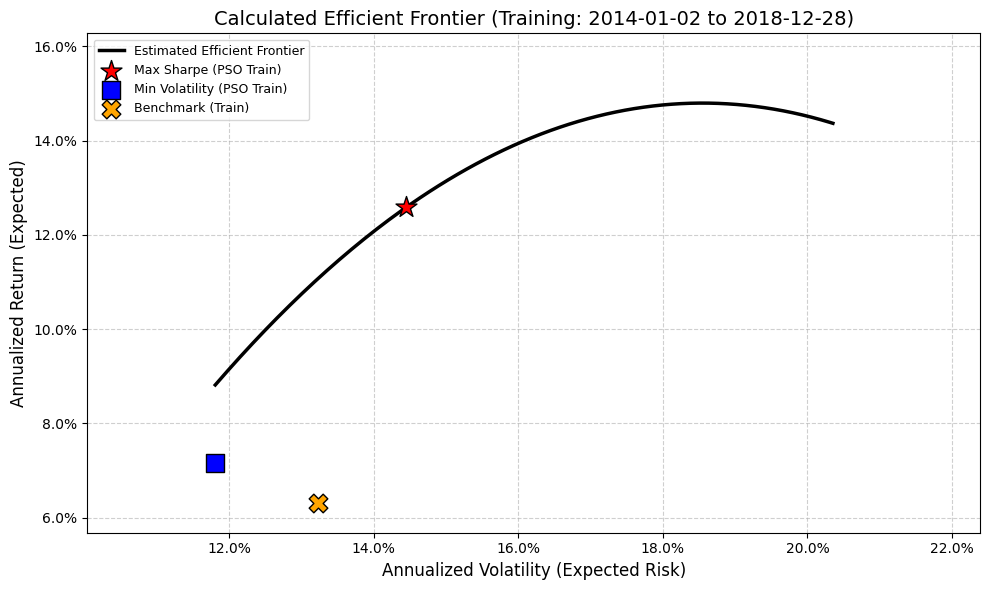


--- Out-of-Sample Performance Evaluation (2019-01-01 to 2023-12-31) ---

Calculating Out-of-Sample Performance Metrics...

--- Out-of-Sample Performance Metrics ---
                  Cumulative Return Annualized Return Annualized Volatility Sharpe Ratio
PSO Max Sharpe              151.70%             20.3%                 21.0%         0.84
PSO Min Vol                  78.25%             12.3%                 18.8%         0.51
S&P 500 Benchmark            90.03%             13.7%                 21.3%         0.52

Plotting Out-of-Sample Results...


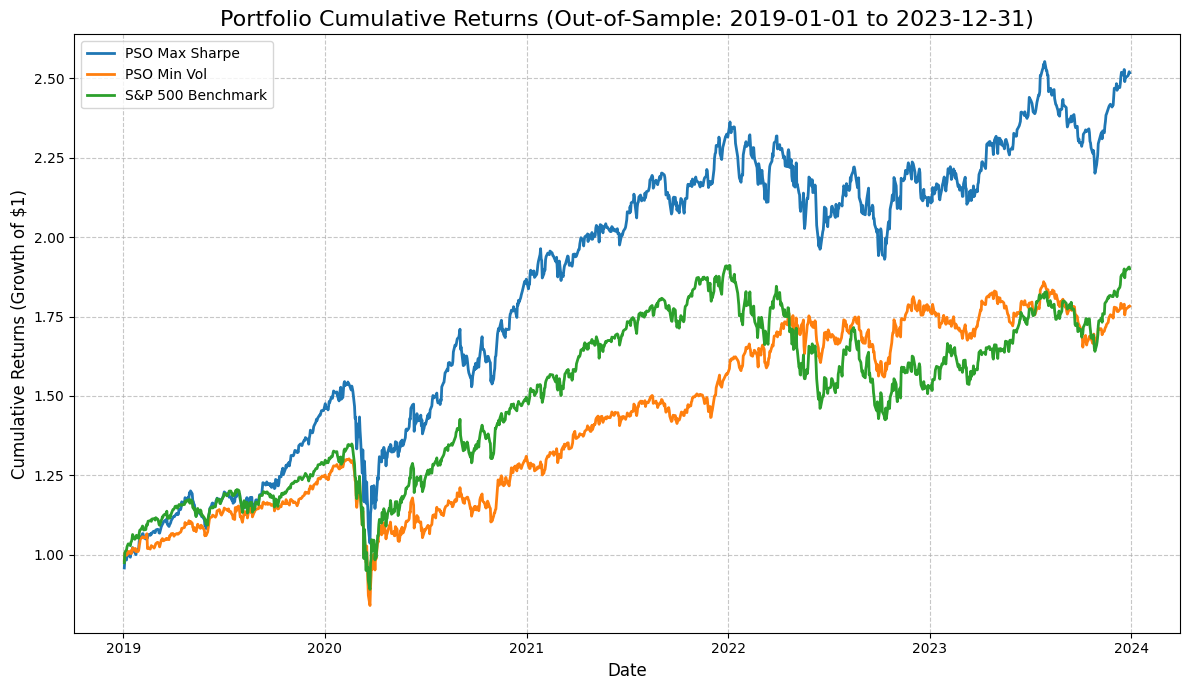

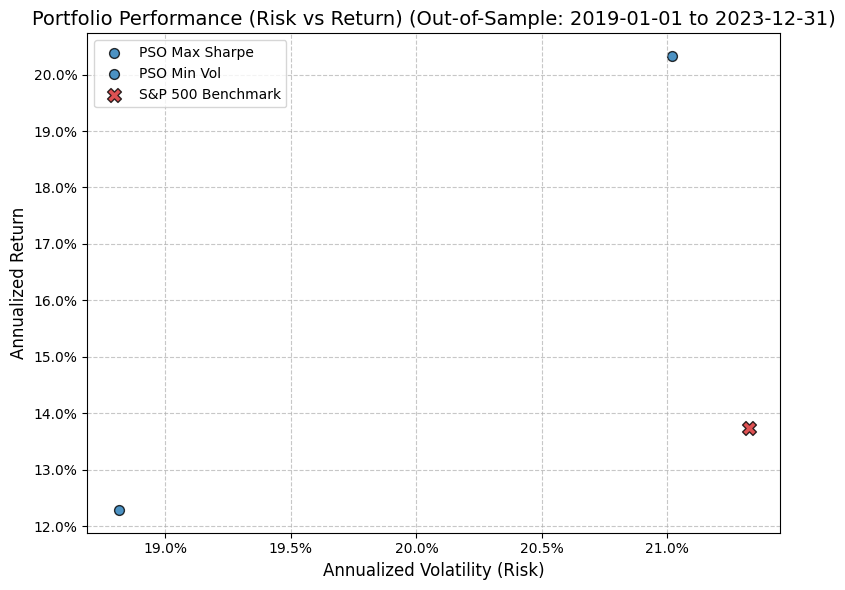

In [104]:
# --- Main Execution Block ---
# This block runs only when the script is executed directly (not imported as a module).
if __name__ == "__main__":

    # --- Configuration ---
    # Define the list of assets to include in the portfolio
    portfolio_tickers = ['AAPL', 'KO', 'JNJ', 'XOM', 'JPM'] # Example: Apple, Coca-Cola, J&J, Exxon, JPMorgan
    # Define the benchmark ticker (e.g., S&P 500 index)
    benchmark_ticker = '^GSPC'
    # Define the date ranges for training (optimization) and testing (out-of-sample evaluation)
    train_start = "2014-01-01"
    train_end = "2018-12-31"
    test_start = "2019-01-01"
    test_end = "2023-12-31"
    # Define risk-free rates for each period (as annual rates, e.g., 0.02 = 2%)
    # These should ideally reflect the prevailing rates for the respective periods.
    train_rf_rate = 0.02  # Example rate for 2014-2018
    test_rf_rate = 0.027 # Example average rate for 2019-2023 (higher due to recent hikes)
    # --- PSO parameters ---
    pso_particles = 50     # Number of particles in the swarm (higher can explore more, but slower)
    pso_iterations = 150    # Number of iterations PSO runs (higher allows more convergence time)
    # --- Efficient Frontier plotting parameters ---
    ef_simulations = 15000 # Number of random portfolios to generate for the EF plot cloud
    ef_poly_degree = 2     # Degree of the polynomial for smoothing the EF curve (2=quadratic)


    # --- Data Loading ---
    print("--- Data Loading ---")
    print(f"Training Period: {train_start} to {train_end}")
    print(f"Testing Period:  {test_start} to {test_end}")
    # Load training data for the portfolio assets
    prices_train = get_data(portfolio_tickers, train_start, train_end)
    # Load testing data for portfolio assets AND the benchmark
    all_tickers_test = portfolio_tickers + [benchmark_ticker]
    prices_test_combined = get_data(all_tickers_test, test_start, test_end)

    # --- Validate loaded data ---
    if prices_train.empty:
        raise ValueError("Training price data is empty. Check tickers, date range, and internet connection.")
    if prices_test_combined.empty:
        raise ValueError("Combined test price data is empty. Check tickers, date range, and internet connection.")

    # --- Prepare Test Data ---
    # Ensure `prices_test` contains only the portfolio tickers (needed for evaluating portfolio weights)
    # Check if all required portfolio tickers were successfully downloaded for the test period
    missing_test_tickers = [t for t in portfolio_tickers if t not in prices_test_combined.columns]
    if missing_test_tickers:
        print(f"Warning: Could not retrieve all portfolio tickers for the test period. Missing: {missing_test_tickers}")
        # Use only the tickers that were successfully downloaded for testing the portfolio
        available_tickers_test = [t for t in portfolio_tickers if t in prices_test_combined.columns]
        prices_test = prices_test_combined[available_tickers_test]
        # Update portfolio_tickers list to reflect only available ones for testing?
        # Depending on downstream use, might be needed. For now, prices_test is filtered.
        if not available_tickers_test:
             raise ValueError("No portfolio tickers available in the test data after filtering.")
    else:
        # If all tickers are present, just select them
        prices_test = prices_test_combined[portfolio_tickers]

    # Extract benchmark prices separately for the test period
    benchmark_prices_test = None
    if benchmark_ticker in prices_test_combined.columns:
        # Select the benchmark column, keeping it as a DataFrame
        benchmark_prices_test = prices_test_combined[[benchmark_ticker]]
    else:
        print(f"Warning: Benchmark ticker {benchmark_ticker} not found in downloaded test data.")


    # --- PSO Optimization on Training Data ---
    # The pso_optimize function performs PSO using historical simulation within its fitness function,
    # but reports the final performance metrics (return, vol, sharpe) calculated MVO-style (using mu/sigma from training data).
    print("\n--- PSO Optimization Results (Training Period) ---")

    # --- Optimize for Maximum Sharpe Ratio ---
    print("\nOptimizing for Max Sharpe Ratio...")
    weights_sharpe, perf_sharpe_train = pso_optimize(prices_train, train_rf_rate, "max_sharpe", pso_particles, pso_iterations)
    print("\n--- Max Sharpe Ratio Portfolio (Training) ---")
    # Check if optimization succeeded and performance is valid
    if perf_sharpe_train and pd.notna(perf_sharpe_train.get('Sharpe Ratio')):
        # Print formatted performance metrics
        print(f"  Expected annual return: {perf_sharpe_train['Annualized Return']:.1%}")
        print(f"  Annual volatility: {perf_sharpe_train['Annualized Volatility']:.1%}")
        print(f"  Sharpe Ratio: {perf_sharpe_train['Sharpe Ratio']:.2f}")
    else:
        print("  Could not calculate Max Sharpe training performance (Optimization likely failed).")
    # Print the optimal weights found
    if weights_sharpe:
        print("  Optimal Weights:")
        # Sort weights descending for readability
        sorted_weights = dict(sorted(weights_sharpe.items(), key=lambda item: item[1], reverse=True))
        for ticker, weight in sorted_weights.items():
             if abs(weight) > 1e-5: # Only show weights > 0.001%
                print(f"    {ticker}: {weight:.3f}")
    else:
        print("  Could not find optimal Max Sharpe weights.")

    # --- Optimize for Minimum Volatility ---
    print("\nOptimizing for Min Volatility...")
    weights_minvol, perf_minvol_train = pso_optimize(prices_train, train_rf_rate, "min_vol", pso_particles, pso_iterations)
    print("\n--- Min Volatility Portfolio (Training) ---")
    # Check if optimization succeeded and performance is valid
    if perf_minvol_train and pd.notna(perf_minvol_train.get('Annualized Volatility')):
        # Print formatted performance metrics
        print(f"  Expected annual return: {perf_minvol_train['Annualized Return']:.1%}")
        print(f"  Annual volatility: {perf_minvol_train['Annualized Volatility']:.1%}")
        print(f"  Sharpe Ratio: {perf_minvol_train['Sharpe Ratio']:.2f}")
    else:
        print("  Could not calculate Min Volatility training performance (Optimization likely failed).")
    # Print the optimal weights found
    if weights_minvol:
        print("  Optimal Weights:")
        # Sort weights descending for readability
        sorted_weights = dict(sorted(weights_minvol.items(), key=lambda item: item[1], reverse=True))
        for ticker, weight in sorted_weights.items():
            if abs(weight) > 1e-5: # Only show weights > 0.001%
                print(f"    {ticker}: {weight:.3f}")
    else:
        print("  Could not find optimal Min Volatility weights.")


    # --- Calculate Benchmark Performance (Training Period) ---
    # This is needed to plot the benchmark's position on the Efficient Frontier plot.
    print("\nCalculating Benchmark Performance (Training Period)...")
    # Fetch benchmark data specifically for the training period
    benchmark_prices_train = get_data([benchmark_ticker], train_start, train_end)
    perf_benchmark_train = {} # Initialize dictionary to store benchmark training performance

    # Check if benchmark data was loaded successfully
    if benchmark_prices_train is not None and not benchmark_prices_train.empty:
        # Calculate daily returns - ensure calculation is done on the Series (first column)
        benchmark_returns_train = benchmark_prices_train.iloc[:, 0].pct_change().dropna()
        # Check if returns calculation was successful
        if not benchmark_returns_train.empty:
            # Calculate annualized return, volatility, and Sharpe ratio using the defined functions
            bench_ann_ret_train = cal_returns(benchmark_returns_train)
            bench_ann_vol_train = cal_volatility(benchmark_returns_train)
            bench_sharpe_train = cal_sharpe_ratio(bench_ann_ret_train, bench_ann_vol_train, train_rf_rate) # Use TRAIN risk-free rate
            # Store results
            perf_benchmark_train = {'Annualized Return': bench_ann_ret_train, 'Annualized Volatility': bench_ann_vol_train, 'Sharpe Ratio': bench_sharpe_train}
            print("\n--- Benchmark Performance (Training) ---")
            print(f"  Annualized Return: {perf_benchmark_train['Annualized Return']:.1%}")
            print(f"  Annualized Volatility: {perf_benchmark_train['Annualized Volatility']:.1%}")
            print(f"  Sharpe Ratio: {perf_benchmark_train['Sharpe Ratio']:.2f}")
        else:
            print("Benchmark training returns series is empty after calculation.")
    else:
        print("Could not calculate benchmark training performance (Data loading failed or empty).")


    # --- Plot Efficient Frontier (Based on Training Data) ---
    print("\nPlotting Efficient Frontier (Training Data)...")
    # Ensure performance dictionaries exist, even if empty, to avoid errors in the plot function call
    if 'perf_sharpe_train' not in locals() or not perf_sharpe_train: perf_sharpe_train = {}
    if 'perf_minvol_train' not in locals() or not perf_minvol_train: perf_minvol_train = {}
    if 'perf_benchmark_train' not in locals() or not perf_benchmark_train: perf_benchmark_train = {}

    # Plot only if training price data is available
    if not prices_train.empty:
        # Call the plotting function with training data and results
        plot_efficient_frontier(
            prices_train,           # Training prices
            train_rf_rate,          # Training risk-free rate
            perf_sharpe_train,      # Max Sharpe training performance
            perf_minvol_train,      # Min Vol training performance
            perf_benchmark_train,   # Benchmark training performance
            ef_simulations,         # Number of simulations for EF cloud
            ef_poly_degree          # Polynomial degree for smoothing
        )
    else:
        # Skip plotting if training data is missing
        print("Skipping efficient frontier plot: Training price data is empty or failed to load.")


    # --- Out-of-Sample Evaluation (Testing Period) ---
    # Evaluate how the portfolios optimized on training data performed on unseen future data.
    print(f"\n--- Out-of-Sample Performance Evaluation ({test_start} to {test_end}) ---")
    portfolio_return_series = {} # Dictionary to store daily return Series for each strategy in the test period

    # --- Calculate Max Sharpe Portfolio Returns (Out-of-Sample) ---
    if 'weights_sharpe' in locals() and weights_sharpe:
        # IMPORTANT: Align weights found during training with the columns of the TEST data.
        aligned_weights_sharpe = pd.Series(weights_sharpe).reindex(prices_test.columns, fill_value=0.0)
        weights_sum_sharpe = aligned_weights_sharpe.sum()
        if not np.isclose(weights_sum_sharpe, 1.0) and weights_sum_sharpe != 0:
            print(f"Warning: Max Sharpe weights sum ({weights_sum_sharpe:.4f}) after alignment for test period was not 1. Normalizing.")
            aligned_weights_sharpe /= weights_sum_sharpe # Re-normalize
        elif np.isclose(weights_sum_sharpe, 0):
            print("Warning: Max Sharpe weights sum to zero after alignment. Cannot calculate test returns.")
            portfolio_return_series['PSO Max Sharpe'] = None # Mark as unavailable
        else:
            portfolio_return_series['PSO Max Sharpe'] = portfolio_returns(prices_test, aligned_weights_sharpe.values)
    else:
        print("Warning: Max Sharpe weights not available from training. Cannot evaluate on test data.")
        portfolio_return_series['PSO Max Sharpe'] = None

    # --- Calculate Min Volatility Portfolio Returns (Out-of-Sample) ---
    if 'weights_minvol' in locals() and weights_minvol:
        # Align Min Vol weights with TEST data columns
        aligned_weights_minvol = pd.Series(weights_minvol).reindex(prices_test.columns, fill_value=0.0)
        weights_sum_minvol = aligned_weights_minvol.sum()
        if not np.isclose(weights_sum_minvol, 1.0) and weights_sum_minvol != 0:
            print(f"Warning: Min Volatility weights sum ({weights_sum_minvol:.4f}) after alignment for test period was not 1. Normalizing.")
            aligned_weights_minvol /= weights_sum_minvol # Re-normalize
        elif np.isclose(weights_sum_minvol, 0):
            print("Warning: Min Volatility weights sum to zero after alignment. Cannot calculate test returns.")
            portfolio_return_series['PSO Min Vol'] = None
        else:
            portfolio_return_series['PSO Min Vol'] = portfolio_returns(prices_test, aligned_weights_minvol.values)
    else:
        print("Warning: Min Volatility weights not available from training. Cannot evaluate on test data.")
        portfolio_return_series['PSO Min Vol'] = None

    # --- Calculate Benchmark Returns (Out-of-Sample) ---
    if benchmark_prices_test is not None and not benchmark_prices_test.empty:
        benchmark_returns_test = benchmark_prices_test.iloc[:, 0].pct_change().dropna()
        if not benchmark_returns_test.empty:
            portfolio_return_series['S&P 500 Benchmark'] = benchmark_returns_test
        else:
            print("Warning: Benchmark test returns series is empty after calculation.")
            portfolio_return_series['S&P 500 Benchmark'] = None
    else:
        portfolio_return_series['S&P 500 Benchmark'] = None


    # --- Align Returns and Calculate Performance Metrics (Test Period) ---
    # Filter out any strategies where returns calculation failed (value is None or Series is empty)
    valid_returns_series = {k: v for k, v in portfolio_return_series.items() if v is not None and not v.empty}

    results_df = pd.DataFrame() # Initialize empty DataFrame for results
    portfolio_returns_aligned = {} # Initialize empty dict for aligned returns

    if valid_returns_series:
        # Find the common date index across all valid return series to ensure fair comparison
        common_index = None
        for series in valid_returns_series.values():
            if common_index is None: # Initialize with the first series' index
                common_index = series.index
            else: # Find the intersection with subsequent series' indices
                common_index = common_index.intersection(series.index)

        # Proceed only if a common index is found (i.e., there's overlap in dates)
        if common_index is not None and not common_index.empty:
            # Align all valid series to the common date index
            portfolio_returns_aligned = {k: v.loc[common_index] for k, v in valid_returns_series.items()}

            metrics = {} # Dictionary to store calculated metrics for the test period
            print("\nCalculating Out-of-Sample Performance Metrics...")

            # Calculate metrics for each strategy using the aligned return series
            for name, returns_series in portfolio_returns_aligned.items():
                if returns_series.empty:
                    print(f"Warning: Returns series for '{name}' is empty after alignment to common index.")
                    metrics[name] = {'Cumulative Return': np.nan, 'Annualized Return': np.nan, 'Annualized Volatility': np.nan, 'Sharpe Ratio': np.nan}
                    continue # Skip to the next strategy

                # Calculate performance metrics using the functions defined earlier
                ann_ret = cal_returns(returns_series)
                ann_vol = cal_volatility(returns_series)
                sharpe = cal_sharpe_ratio(ann_ret, ann_vol, test_rf_rate) # Use TEST RF rate
                base = (1 + returns_series)
                cumulative_return = base.prod() - 1

                # Store the calculated metrics
                metrics[name] = {
                    'Cumulative Return': cumulative_return,
                    'Annualized Return': ann_ret,
                    'Annualized Volatility': ann_vol,
                    'Sharpe Ratio': sharpe
                }

            # Convert the metrics dictionary to a pandas DataFrame for display
            if metrics:
                results_df = pd.DataFrame.from_dict(metrics, orient='index')
                print("\n--- Out-of-Sample Performance Metrics ---")
                # Define formatting for printing the results DataFrame nicely
                formatters = {
                    'Cumulative Return': lambda x: '{:,.2%}'.format(x) if pd.notna(x) else 'N/A', # Format as percentage
                    'Annualized Return': lambda x: '{:,.1%}'.format(x) if pd.notna(x) else 'N/A', # Format as percentage (1 decimal)
                    'Annualized Volatility': lambda x: '{:,.1%}'.format(x) if pd.notna(x) else 'N/A',# Format as percentage (1 decimal)
                    'Sharpe Ratio': lambda x: '{:,.2f}'.format(x) if pd.notna(x) else 'N/A',      # Format as float with 2 decimals
                }
                # Print the DataFrame using the specified formatters, converting to string first
                print(results_df.to_string(formatters=formatters))
            else:
                print("\nNo performance metrics could be calculated for the test period.")
                # results_df remains empty

        else:
            print("\nNo common date index found for aligning test returns data. Cannot calculate metrics.")
            # results_df and portfolio_returns_aligned remain empty

    else:
        print("\nNo valid portfolio returns generated to evaluate for the test period.")
        # results_df and portfolio_returns_aligned remain empty

    # --- Plotting (Test Period Performance) ---
    print("\nPlotting Out-of-Sample Results...")

    # Plot cumulative returns if aligned data is available
    if 'portfolio_returns_aligned' in locals() and portfolio_returns_aligned:
        plot_cumulative_returns(portfolio_returns_aligned, title_suffix=f"(Out-of-Sample: {test_start} to {test_end})")
    else:
        print("Skipping cumulative returns plot: No aligned returns data for the test period.")

    # Plot risk-return scatter plot if results DataFrame is available
    if 'results_df' in locals() and not results_df.empty:
        plot_risk_return(results_df, title_suffix=f"(Out-of-Sample: {test_start} to {test_end})")
    else:
        print("Skipping risk-return plot: No performance metrics data calculated for the test period.")